<h2>Libraries</h2>

In [1]:
# Import necessary libraries for processing
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Utility
import math
import scipy.io.wavfile as wf  #wave file reader

In [3]:
# Feature extraction
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
# CNN
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.optimizers import Adam

In [5]:
# Results
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

<h2>Data processing</h2>

In [6]:
df_no_diagnosis = pd.read_csv('C:/Users/user/Desktop/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')
diagnosis = pd.read_csv('C:/Users/user/Desktop/patient_diagnosis.csv', 
                        names = ['Patient number', 'Diagnosis'])

In [7]:
# Combine diagnosis data with patient data
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

Text(0.5, 1.0, 'Disease Count in Patient Diagnosis')

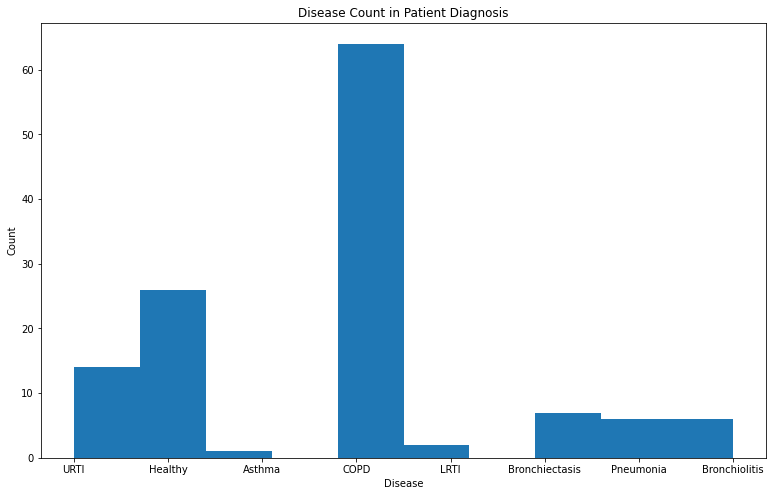

In [8]:
plt.figure(figsize=(13,8))
plt.hist(df['Diagnosis'])
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Patient Diagnosis')

In [9]:
root =  'C:/Users/user/Desktop/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [10]:
filenames

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200',
 '105_1b1_Tc_sc_Meditron',
 '106_2b1_Pl_mc_LittC2SE',
 '106_2b1_Pr_mc_LittC2SE',
 '107_2b3_Al_mc_AKGC417L',
 '107_2b3_Ar_mc_AKGC417L',
 '107_2b3_Ll_mc_AKGC417L',
 '107_2b3_Lr_mc_AKGC417L',
 '107_2b3_Pl_mc_AKGC417L',
 '107_2b3_Pr_mc_AKGC417L',
 '107_2b3_Tc_mc_AKGC417L',
 '107_2b4_Al_mc_AKGC417L',
 '107_2b4_Ar_mc_AKGC417L',
 '107_2b4_Ll_mc_AKGC417L',
 '107_2b4_Lr_mc_AKGC417L',
 '107_2b4_Pl_mc_AKGC417L',
 '107_2b4_Pr_mc_AKGC417L',
 '107_2b4_Tc_mc_AKGC417L',
 '107_2b5_Al_mc_AKGC417L',
 '107_2b5_Ar_mc_AKGC417L',
 '107_2b5_Ll_mc_AKGC417L',
 '107_2b5_Lr_mc_AKGC417L',
 '107_2b5_Pl_mc_AKGC417L',
 '107_2b5_Pr_mc_AKGC417L',
 '107_2b5_Tc_mc_AKGC417L',
 '107_3p2_Al_mc_AKGC417L',
 '107_3p2_Ar_mc_AKGC417L',
 '107_3p2_Ll_mc_AKGC417L',
 

In [71]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return recording_info, recording_annotations

In [73]:
print(df.loc[df['Patient number'] == 130])
print('-------*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*----------------')
Extract_Annotation_Data('130_1p2_Ll_mc_AKGC417L', root)

    Patient number   Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
29             130  85.0   F               17.1                NaN   

    Child Height (cm) Diagnosis  
29                NaN      COPD  
-------*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*----------------


(  Patient number Recording index Chest location Acquisition mode  \
 0            130             1p2             Ll               mc   
 
   Recording equipment  
 0            AKGC417L  ,
     Start     End  Crackles  Wheezes
 0   0.697   2.423         1        1
 1   2.423   5.101         1        1
 2   5.101   8.339         1        1
 3   8.339  11.280         1        1
 4  11.280  14.316         1        1
 5  14.316  17.030         1        1
 6  17.030  19.554         1        1)

In [106]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    print(i)

  Patient number Recording index Chest location Acquisition mode  \
0            101             1b1             Al               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            101             1b1             Pr               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            102             1b1             Ar               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            103             2b2             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            104             1b1             Al               sc   

  Recording equipment  
0            Litt3200  
  Patient number Recording index Chest location Acquisition mode  \
0      

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            114             1b4             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            114             1b4             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            115             1b1             Ar               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            116             1b2             Pl               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            116             1b2             Tc               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             1p3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             1p3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             1p4             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             1p4             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             1p4             Ll               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

  Patient number Recording index Chest location Acquisition mode  \
0            130             3p3             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             3p3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             3p3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             3p3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            130             3p4             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0      

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            138             1p3             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            138             1p3             Ll               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            138             1p3             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            138             1p3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            138             1p3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            146             8p3             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            146             8p3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            146             8p3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            147             1b2             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            147             1b3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            154             1b3             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            154             1b3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            154             1b3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            154             1b3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            154             2b4             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            158             1p2             Ll               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            158             1p2             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            158             1p2             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            158             1p2             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            158             1p2             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            162             1b2             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            162             2b2             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            162             2b2             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            162             2b2             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            162             2b2             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            170             1b2             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            170             1b2             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            170             1b2             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            170             1b2             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            170             1b3             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            172             2b5             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            172             2b5             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            172             2b5             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            173             1b1             Al               sc   

  Recording equipment  
0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            174             1p2             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            176             2b3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            176             2b3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            176             2b3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            177             1b2             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            177             1b2             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            180             1b4             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            180             1b4             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            180             1b4             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            181             1b1             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            181             1b1             Tc               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acq

0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            192             2b2             Al               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            192             2b2             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            192             2b3             Al               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            192             2b3             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            193             1b2             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            200             2p3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            200             2p3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            200             2p3             Tc               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            200             2p4             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            200             2p4             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            205             1b3             Lr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            205             1b3             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            205             1b3             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            205             2b2             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            205             2b3             Al               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            Meditron  
  Patient number Recording index Chest location Acquisition mode  \
0            211             1p2             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            211             1p2             Pl               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            211             1p2             Pr               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            211             1p3             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acquisition mode  \
0            211             1p5             Ar               mc   

  Recording equipment  
0            AKGC417L  
  Patient number Recording index Chest location Acq

0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            221             2b1             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            221             2b1             Lr               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            221             2b1             Pl               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            221             2b2             Al               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acquisition mode  \
0            221             2b2             Ar               mc   

  Recording equipment  
0            LittC2SE  
  Patient number Recording index Chest location Acq

ValueError: 5 columns passed, passed data had 2 columns

In [83]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

KeyError: '101_1b1_Al_sc_Meditron'

In [103]:
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]